# Kaggle TGS Geoseismic competition

In [0]:
!wget -q https://raw.githubusercontent.com/douglas125/McLyEdSegmentation/master/DeepLabv3Plus.py
!wget -q https://raw.githubusercontent.com/douglas125/McLyEdSegmentation/master/ImageReader.py
!wget -q https://raw.githubusercontent.com/douglas125/McLyEdSegmentation/master/ModelUNet.py
!wget -q https://raw.githubusercontent.com/douglas125/McLyEdSegmentation/master/models.py
!wget -q https://raw.githubusercontent.com/douglas125/McLyEdSegmentation/master/requirements.txt

In [0]:
!pip install -r requirements.txt

In [4]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [0]:
!mkdir ~/.kaggle
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [0]:
!kaggle competitions download -c tgs-salt-identification-challenge

# Data Exploration

In [0]:
import zipfile
zip_ref = zipfile.ZipFile('train.zip', 'r')
zip_ref.extractall('tgs-salt-identification-challenge/trainData')
zip_ref.close()

In [0]:
zip_ref = zipfile.ZipFile('test.zip', 'r')
zip_ref.extractall('tgs-salt-identification-challenge/testData')
zip_ref.close()

In [8]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tqdm import tqdm_notebook, tnrange, tqdm

from scipy.signal import medfilt2d

Using TensorFlow backend.


In [0]:
trainFolder = 'tgs-salt-identification-challenge/trainData/'
testFolder  = 'tgs-salt-identification-challenge/testData/'

In [0]:
depthFile = pd.read_csv('depths.csv' )
depthFile.head()

In [0]:
%load_ext autoreload
%autoreload 2

import ImageReader

In [0]:
train_ids = next(os.walk(trainFolder +"images"))[2]
test_ids = next(os.walk(testFolder +"images"))[2]

In [0]:
ImageReader.ignoreList = []

In [13]:
X_train, Y_train, depthVals = ImageReader.ReadSegmentationImages(trainFolder, depthFile)
X_train = X_train/255.0

  0%|          | 19/4000 [00:00<00:21, 188.58it/s]

Getting images and masks ... 


100%|██████████| 4000/4000 [00:16<00:00, 239.23it/s]


Mean: 120.34612148318793 Std: 41.0696652201621


# Keras datagen

In [14]:
valRatio = 0.04
nVal = int(len(X_train)*valRatio)
X_val = X_train[0:nVal]
Y_val = Y_train[0:nVal]
d_val = depthVals[0:nVal]

X_train0 = X_train[nVal:]
Y_train0 = Y_train[nVal:]
d_train0 = depthVals[nVal:]
X_train0.shape
print('{}, {}, {}'.format(X_train0.shape, X_val.shape, d_val.shape))

(3840, 101, 101, 1), (160, 101, 101, 1), (160, 1, 1, 1)


In [0]:
from keras.preprocessing.image import ImageDataGenerator

# we create two instances with the same arguments
data_gen_argsMask = dict(
                     rotation_range=3.0, #1.0,
                     #shear_range = 0.001, #0
                     zoom_range = 0.013, #0
                     width_shift_range=0.11, # 0.03,
                     height_shift_range=0.2, #0.3,
                     horizontal_flip=True,
                     cval=0,
                     fill_mode = "reflect"  #reflect
                     #vertical_flip=True #see if helps
                    )

data_gen_args = {}
for key in data_gen_argsMask:
    data_gen_args[key] = data_gen_argsMask[key]
    
#data_gen_args['featurewise_center'] = True
#data_gen_args['featurewise_std_normalization'] = True
#data_gen_args['zca_whitening'] = True #this or normalization

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_argsMask)
depth_datagen = ImageDataGenerator()


seed=7
# Provide the same seed and keyword arguments to the fit and flow methods
image_datagen.fit(X_train0, augment=True, seed=seed)
#mask_datagen.fit(Y_train0, augment=True, seed=seed)
#depth_datagen.fit(d_train0, augment=False, seed=seed)

image_generator = image_datagen.flow(
    X_train0,
    seed=seed,
    batch_size = 32)#32*nGPUs)

mask_generator = mask_datagen.flow(
    Y_train0,
    seed=seed,
    batch_size = 32)#32*nGPUs)

depth_generator = depth_datagen.flow(
    d_train0,
    seed=seed,
    batch_size = 32)#32*nGPUs)

bSize = 32
def multi_input_gen(X1, X2, X3):
    genX1 = image_datagen.flow(X1, seed=7, batch_size=bSize)
    genX2 = depth_datagen.flow(X2, seed=7, batch_size=bSize)
    genX3 = mask_datagen.flow( X3, seed=7, batch_size=bSize)
    while True:
            X1i = genX1.next()
            X2i = genX2.next()
            X3i = genX3.next()
            yield [X1i, X2i], X3i

train_generator = multi_input_gen(X_train0, d_train0, Y_train0) #zip( [image_generator, depth_generator] , [mask_generator] )

## DeepLabV3+

In [0]:
from keras.utils import plot_model
from keras.models import Model, load_model
from keras.layers import Input, ZeroPadding2D, Cropping2D, Add, Conv2D, Concatenate
from keras.layers.core import Lambda

In [17]:
import DeepLabv3Plus
import ModelUNet

im_height = 101
im_width = 101
im_chan = 1


inputs = Input((im_height, im_width, im_chan))
#s = Lambda(lambda x: x / 255) (inputs)
s=inputs
inputDepth = Input( (1,1,1) )


curLayer = inputs#Concatenate()([inputs, depthIn])


#s = ReflectionPadding2D( padding = ((13, 14), (13, 14)) ) (s)
s = ZeroPadding2D( padding = ((13, 14), (13, 14)) ) (curLayer)
s = Conv2D(3, (1, 1), activation='relu') (s) #(1,1)

dlmodel = DeepLabv3Plus.Deeplabv3(input_shape=(128, 128, 3), classes=21, backbone='xception') #xception

outputs = dlmodel(s)

dd = Lambda(lambda x: x * 0.001) (inputDepth)
dd = Lambda(lambda x: ModelUNet._expand(x, 128, 128) )(dd)
outputs = Concatenate()([outputs, dd])

outputs = Conv2D(1, (1, 1), activation='sigmoid') (outputs)
outputs = Cropping2D(cropping=((13, 14), (13, 14)) ) (outputs)

#model = Model(inputs=[inputs], outputs=[outputs, outputs])
#model.compile(optimizer='adam', loss=['binary_crossentropy', dice_loss], loss_weights=[0.01, 1.2], metrics=[mean_iou])
model = Model(inputs=[inputs, inputDepth], outputs=outputs)
model.compile(optimizer='adam', loss=[ModelUNet.dice_loss], metrics=[ModelUNet.mean_iou])
model.summary()

8986624/8986568 [==============================] - 1s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 101, 101, 1)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 128, 128, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1, 1, 1)      0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 3)  6           zero_padding2d_1[0][0]           
______________________________________________

# Training

In [0]:
import math
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
def step_decay(epoch):
    initial_lrate = 1e-3               
    drop = 0.6
    epochs_drop = 25
    lrate = initial_lrate * math.pow(drop,  
            math.floor((1+epoch)/epochs_drop))
    
    if (lrate < 1e-6):
        lrate = 1e-6
      
    print('Changing learning rate to {}'.format(lrate))
    return lrate
lrate = LearningRateScheduler(step_decay)

In [0]:
earlystopper = EarlyStopping(patience=90, verbose=1)
checkpointer = ModelCheckpoint('model-tgs-salt-1.h5', verbose=1, save_best_only=True)
internalEval = ModelUNet.IntervalEvaluation( validation_data=( [X_val, d_val], Y_val), interval = 1 )
#results = model.fit([X_train0, d_train0], Y_train0, validation_split=0.08, batch_size=16, epochs=100, 
#                    callbacks=[earlystopper, checkpointer, lrate])

results = model.fit_generator(train_generator, epochs=250, steps_per_epoch=len(X_train0) / 32, 
                              validation_data=( [X_val, d_val], Y_val),
                              callbacks=[earlystopper, checkpointer, lrate, internalEval])


In [0]:
plt.plot(internalEval.score_list[4:])

In [0]:
# list all data in history
print(results.history.keys())

dict_keys(['val_loss', 'loss', 'val_mean_iou', 'mean_iou'])


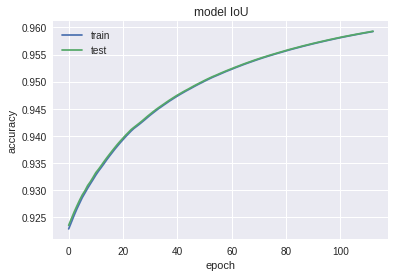

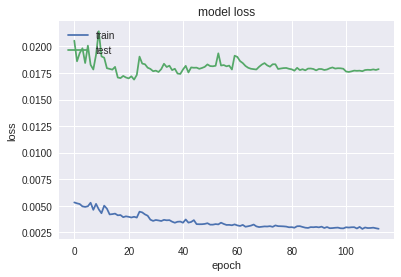

In [74]:
# summarize history for intersestion over union
plt.plot(results.history['mean_iou'])
plt.plot(results.history['val_mean_iou'])
plt.title('model IoU')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

saved_model = drive.CreateFile({'id': '1tixSI8-5xHGAko3KXSEdksTb466xSOwQ'}) #1Qfmpxsf8Yqz30Qkip8oyuGug6QC-jqUX
saved_model.GetContentFile('model-tgs-salt-IV.h5')

In [0]:
model = load_model('model-tgs-salt-IV.h5', custom_objects={'mean_iou': ModelUNet.mean_iou, 'dice_loss' : ModelUNet.dice_loss, 'ModelUNet': ModelUNet,
                                                           '_expand': ModelUNet._expand, 'relu6': DeepLabv3Plus.relu6, 'BilinearUpsampling': DeepLabv3Plus.BilinearUpsampling }) #, 'ReflectionPadding2D' : ReflectionPadding2D})
#model.save('model-tgs-salt-1.h5')

In [0]:
#from google.colab import files
#files.download('model-tgs-salt-1.h5')
#files.upload()

In [0]:
#for i in tqdm(range(len(X_train0))):
#    X_train0[i] = image_datagen.standardize(X_train0[i].astype(float))
    
#for i in tqdm(range(len(X_val))):
#    X_val[i] = image_datagen.standardize(X_val[i].astype(float))

In [75]:
preds_train = model.predict([X_train0, d_train0], verbose=1)
preds_val = model.predict([X_val,d_val], verbose=1)

160/160 [==============================] - 1s 6ms/step


## Watershed

In [0]:
# Perform a sanity check on some random training samples
from skimage.morphology import watershed

ix = np.random.randint(0, len(preds_val))
ix=64

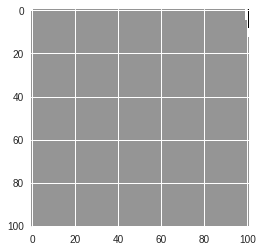

In [77]:
markers = np.zeros_like(preds_val[ix,:,:,0])
markers[preds_val[ix,:,:,0] < 0.1] = 2
markers[preds_val[ix,:,:,0] > 0.4] = 1
plt.imshow(markers)
plt.show()

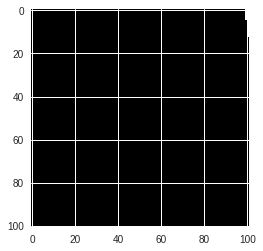

In [78]:
segmentation = watershed(preds_val[ix,:,:,0], markers)
segmentation[segmentation == 2] = 0
plt.imshow(segmentation)

In [0]:
segmentation

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [79]:
threshList = []
IoUList = []
IoUValList = []
for kk in tqdm(range(65)):
    thresh = 0.3 + 0.7*(1+kk)/65
    threshList.append(thresh)
    
    meanIoUVal = 0
    
    preds_val_ws = ModelUNet.WaterShedChangeAll(preds_val, lowThresh = 0.1, highThresh = thresh)
    meanIoUVal = np.array([ModelUNet.IoU(preds_val_ws[i], Y_val[i]) for i in range(Y_val.shape[0])])
    IoUValList.append(np.mean(meanIoUVal) )
    

100%|██████████| 65/65 [00:58<00:00,  1.10it/s]


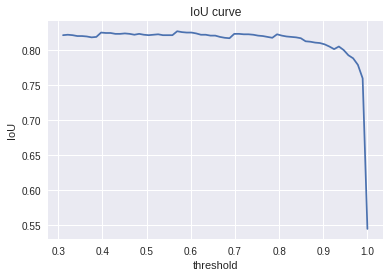

In [80]:
plt.title('IoU curve')
plt.ylabel('IoU')
plt.xlabel('threshold')

#plt.plot(threshList, IoUList)
plt.plot(threshList, IoUValList)

In [81]:
wsThresh = threshList[np.argmax(IoUValList)]
print('Thresh: {}  ExpectedIoU: {}'.format(wsThresh, max(IoUValList)))

Thresh: 0.5692307692307692  ExpectedIoU: 0.8275


## Threshold optimization

In [82]:
threshList = []
IoUList = []
IoUValList = []
for kk in tqdm(range(13)):
    thresh = (1+kk)/13
    threshList.append(thresh)
    preds_train_t = (preds_train > thresh).astype(np.uint8)
    preds_val_t = (preds_val > thresh).astype(np.uint8)
    meanIoU = np.array([ModelUNet.IoU(preds_train_t[i], Y_train0[i]) for i in range(Y_train0.shape[0])])
    IoUList.append(np.mean(meanIoU) )
    meanIoUVal = np.array([ModelUNet.IoU(preds_val_t[i], Y_val[i]) for i in range(Y_val.shape[0])])
    IoUValList.append(np.mean(meanIoUVal) )

100%|██████████| 13/13 [01:43<00:00,  7.95s/it]


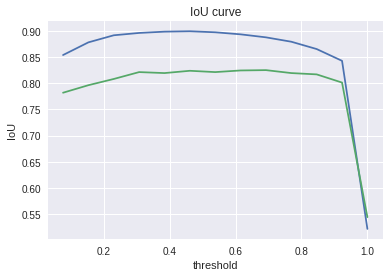

In [83]:
plt.title('IoU curve')
plt.ylabel('IoU')
plt.xlabel('threshold')

plt.plot(threshList, IoUList)
plt.plot(threshList, IoUValList)

In [84]:
thresh = threshList[np.argmax(IoUValList)]
print('Thresh: {}  ExpectedIoU: {}'.format(thresh, max(IoUValList)))

Thresh: 0.6923076923076923  ExpectedIoU: 0.825


In [0]:
thresh = 0.5

# Predictions

In [0]:
X_test, d_test = ImageReader.ReadSegmentationImages(testFolder, depthFile, readMasks = False)
X_test = X_test/255.0 #(X_test-X_train_mean)/(2*X_train_std)

#for i in tqdm(range(len(X_test))):
#    X_test[i] = image_datagen.standardize(X_test[i].astype(float))

In [85]:
# Predict on train, val and test

preds_train = model.predict([X_train0, d_train0], verbose=1)
preds_val = model.predict([X_val, d_val], verbose=1)
preds_test = model.predict([X_test, d_test], verbose=1)


# Threshold predictions
preds_train_t = (preds_train > thresh).astype(np.uint8)
preds_val_t = (preds_val > thresh).astype(np.uint8)
preds_test_t = (preds_test > thresh).astype(np.uint8)


18000/18000 [==============================] - 113s 6ms/step


In [33]:
preds_test = model.predict([X_test, d_test], verbose=1)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

18000/18000 [==============================] - 270s 15ms/step


In [86]:
#Watershed predictions
preds_test_t = ModelUNet.WaterShedChangeAll(preds_test, lowThresh = 0.1, highThresh = wsThresh)

100%|██████████| 18000/18000 [00:57<00:00, 313.69it/s]


In [0]:
lowPixCount = [imgId for imgId in range(len(preds_test_t)) if preds_test_t[imgId].sum() < 5 and preds_test_t[imgId].sum() > 0]
len(lowPixCount)

0

In [0]:
for imId in lowPixCount:
    preds_test_t[imId]=np.zeros( (101,101,1) )

# Prepare Submission

In [87]:
print(preds_test_t.shape)
preds_test = preds_test_t.reshape(preds_test_t.shape[0], preds_test_t.shape[1], preds_test_t.shape[2])
print(preds_test.shape)

(18000, 101, 101, 1)
(18000, 101, 101)


In [88]:
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

pred_dict = {fn[:-4]:RLenc(np.round(preds_test[i])) for i,fn in tqdm(enumerate(test_ids))}
#pred_dict = {fn[:-4]:RLenc(np.round(preds_test[i])) for i,fn in (enumerate(test_ids))}

18000it [07:16, 41.19it/s]


In [0]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')

In [90]:
import zipfile
try:
    import zlib
    compression = zipfile.ZIP_DEFLATED
except:
    compression = zipfile.ZIP_STORED

modes = { zipfile.ZIP_DEFLATED: 'deflated',
          zipfile.ZIP_STORED:   'stored',
          }

print('creating archive')
zf = zipfile.ZipFile('submission.zip', mode='w')
try:
    print('adding with compression mode {}'.format(modes[compression]))
    zf.write('submission.csv', compress_type=compression)
finally:
    print('closing')
    zf.close()

print('submission.zip')

creating archive
adding with compression mode deflated
closing
submission.zip


In [91]:
!kaggle competitions submit -c tgs-salt-identification-challenge -f submission.zip -m "DeepLabv3, initial_lr=1e-3, backbone=xception, watershed"

Successfully submitted to TGS Salt Identification Challenge

In [72]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Create & upload a file.
uploaded = drive.CreateFile({'title': 'model-tgs-salt-IV.h5'})
uploaded.SetContentFile('model-tgs-salt-IV.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1F5nNy6X_zLQB7nNpSasTBl3zWgBiHYwR
